# Brazilian SARS-CoV-2 genomic sequences

With the pandemic, the huge ammount of genomic information with both great sequencing quality and taxonomic labels, which have been previously curated and created by a community of experts, created a great opportunity to study sequence representation, clustering and evolution. 

Unfortunatelly, as ~86K genomes is a huge and infeasible dataset to align and perform ML phylogeny, we used the well stablished augur to subsamble by year-month and obtain ~3K genomes (that are relatively uniform-distributed over time)

Python library importation

In [1]:
import os

R library importation

In [4]:
%load_ext rpy2.ipython

In [18]:
%%R
library(tidyverse)
library(ape)
library(ggtree)
library(tidytree)
library(treeio)
library(castor)
library(ggExtra)
library(reshape2)
library(parallelDist)
library(stylo)
library(phyloTop)
library(dendextend)
library(phangorn)


R[write to console]: 
### stylo version: 0.7.4 ###

If you plan to cite this software (please do!), use the following reference:
    Eder, M., Rybicki, J. and Kestemont, M. (2016). Stylometry with R:
    a package for computational text analysis. R Journal 8(1): 107-121.
    <https://journal.r-project.org/archive/2016/RJ-2016-007/index.html>

To get full BibTeX entry, type: citation("stylo")

R[write to console]: 
---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



In [6]:
os.chdir('nextclade.Brazil.sub.3k/')

In [ ]:
! augur filter --metadata Brazil.metadata.tsv --sequences Brazil.sequences.fasta --group-by year month --no-probabilistic-sampling --output-sequences Brazil.sub.3k.fasta --output-metadata Brazil.sub.3k.metadata.tsv --subsample-max-sequences 3000

We used nextclade tool to align genomes to reference and classify them following Nextclade lineages and WHO clade nomenclature.

In [ ]:
%%bash
sudo /dados/software/nextclade-Linux-x86_64 \
   --in-order \
   --input-fasta Brazil.sub.3k.fasta \
   --input-dataset /data/sars-cov-2 \
   --output-tsv Brazil.sub.3k.nextclade.tsv \
   --output-tree Brazil.sub.3k.nextclade.auspice.json \
   --output-dir nextclade.Brazil.sub.3k/ \
   --output-basename Brazil.sub.3k

Then, we estimated the Maximum-Likelihood tree with IQtree software

### WARNING: this should be only executed in a proper pc or server that can handle large resource consumption!!!

In [ ]:
! iqtree2 -T AUTO -m GTR+I+G -B 1000 --alrt 1000 -s Brazil.sub.3k.aligned.fasta

## Performing Likelihood mapping

In [ ]:
! iqtree2 -T AUTO -m GTR+I+G -n 0 -lmap 75000 -seed 42 -s Brazil.sub.3k.aligned.fasta

### Checking the resulting tree

In [7]:
%%R
meta = read.csv("Brazil.sub.3k.nextclade.tsv", sep="\t", stringsAsFactors = F)
names(meta)[1] = "label"
glimpse(meta)


Rows: 2,951
Columns: 67
$ label                                           <chr> "hCoV-19/Brazil/PB-IEC…
$ clade                                           <chr> "20A", "20A", "20B", "…
$ Nextclade_pango                                 <chr> "B.1.212", "B.1.212", …
$ partiallyAliased                                <chr> "B.1.212", "B.1.212", …
$ clade_nextstrain                                <chr> "20A", "20A", "20B", "…
$ clade_who                                       <chr> "unassigned", "unassig…
$ clade_legacy                                    <chr> "20A", "20A", "20B", "…
$ qc.overallScore                                 <dbl> 0.000000, 0.000000, 0.…
$ qc.overallStatus                                <chr> "good", "good", "good"…
$ totalSubstitutions                              <int> 7, 11, 9, 11, 11, 10, …
$ totalDeletions                                  <int> 0, 0, 0, 0, 0, 0, 1, 2…
$ totalInsertions                                 <int> 0, 0, 0, 0, 0, 0, 0, 0…
$ totalFrameShif

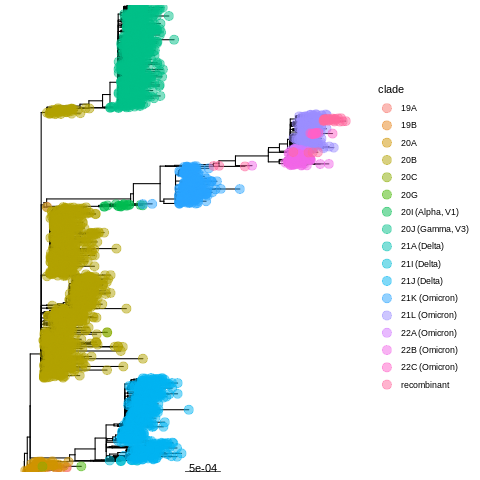

In [8]:
%%R
tree = read.iqtree("Brazil.sub.3k.aligned.fasta.contree") 

p = ggtree(tree, ladderize = T, brach.lenght = T)
p$data = left_join(p$data, meta, by="label") 
p1 = p + geom_tippoint(aes(color = clade), size = 4) +
  geom_treescale(width=0.0005, color="black") + 
  geom_text2(aes(label=label, subset = !is.na(as.numeric(label))), size = 4 , nudge_x = -0.00004, nudge_y = 22) +
  theme(legend.position="right") #+ xlim(-0.3,2.7) 

    
#svg("BR_cladeswithboots.svg", width = 100, height = 50)
#plot(p1)
#dev.off()

p = ggtree(tree, ladderize = T)
p$data = left_join(p$data, meta, by="label") 
p1 = p + geom_tippoint(aes(color = clade), alpha = 0.5, size = 4) +
  geom_treescale(width=0.0005, color='black') + 
  theme(legend.position="right") #+ xlim(-0.3,2.7) 

svg("FIG_BR_clades.svg", width = 10, height = 20)
plot(p1)
dev.off()

p1

As in this huge tree we can't see bootstrap values, a plausible workaround should be plotting the bootstrap values by x coordinates.

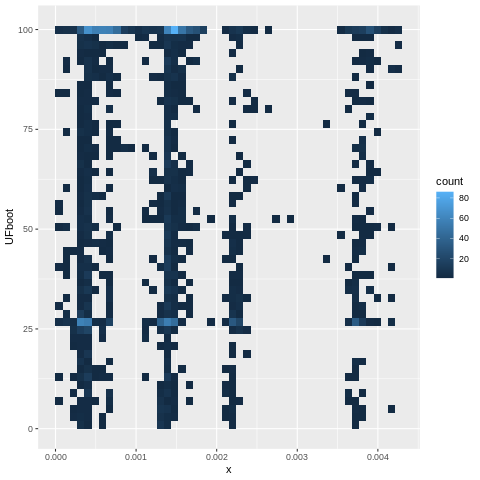

In [9]:
%%R
p$data %>% ggplot(aes(x = x, y = UFboot)) + geom_bin2d(bins = 50)

## Getting numerical representation from ~3K Brazilian sequences

In [31]:
! python3 ../numeric_encoding.py --fasta Brazil.sub.3k.fasta --repr 4-mer --thread 12 #natural 4-mer

File choosed:
Brazil.sub.3k.fasta
Numeric Encoding:
4-mer
Number of threads to use
12
(natural pid=79822) :ta
(natural pid=79822) sk_name:natural


In [32]:
! python3 ../numeric_encoding.py --fasta Brazil.sub.3k.fasta --repr 6-mer --thread 12 #natural 6-mer

File choosed:
Brazil.sub.3k.fasta
Numeric Encoding:
6-mer
Number of threads to use
12
(natural pid=141582) :ta
(natural pid=141582) sk_name:natural
(pid=160673) natural


In [11]:
! python3 ../numeric_encoding.py --fasta Brazil.sub.3k.fasta --repr c-4-mer --thread 12 #natural 4-mer

File choosed:
Brazil.sub.3k.fasta
Numeric Encoding:
c-4-mer
Number of threads to use
12


In [34]:
! python3 ../numeric_encoding.py --fasta Brazil.sub.3k.fasta --repr c-6-mer --thread 12 #natural 6-mer

File choosed:
Brazil.sub.3k.fasta
Numeric Encoding:
c-6-mer
Number of threads to use
12
(natural pid=375525) :
(natural pid=375525) task_name:natural
(pid=445322) natural
(pid=544394) natural
(natural pid=548170) :ta
(natural pid=548170) sk_name:natural


## Comparing the patristic distances from trees and numerical representation

#### Reading data into R

In [13]:
%%R
normalize <- function(x, na.rm = TRUE) {
  return((x- min(x)) /(max(x)-min(x)))
}

tree = read.iqtree("Brazil.sub.3k.aligned.fasta.contree")

meta = read.csv("Brazil.sub.3k.nextclade.tsv", sep="\t", stringsAsFactors = F)
names(meta)[1] = "label"
head(meta)

#fast = read.csv("nextclade.Brazil.sub.3k/Brazil.sub.3k.fasta.fast.csv", sep = ",", header = T, row.names = 2)
#fast[,1] = NULL
#fast = apply(fast, MARGIN = 2, FUN = normalize)

cnat4mer = read.csv("Brazil.sub.3k.fasta.c4natvec.csv", sep = ",", header = T, row.names = 2)
cnat4mer[,1] = NULL
cnat4mer = apply(cnat4mer, MARGIN = 2, FUN = normalize)

cnat6mer = read.csv("Brazil.sub.3k.fasta.c6natvec.csv", sep = ",", header = T, row.names = 2)
cnat6mer[,1] = NULL
cnat6mer = apply(cnat6mer, MARGIN = 2, FUN = normalize)

nat4mer = read.csv("Brazil.sub.3k.fasta.4natvec.csv", sep = ",", header = T, row.names = 2)
nat4mer[,1] = NULL
nat4mer = apply(nat4mer, MARGIN = 2, FUN = normalize)

nat6mer = read.csv("Brazil.sub.3k.fasta.6natvec.csv", sep = ",", header = T, row.names = 2)
nat6mer[,1] = NULL
nat6mer = apply(nat6mer, MARGIN = 2, FUN = normalize)


In [14]:
%%R
excludir = "hCoV-19/Brazil/RS-LMM17042/2020"
nat4mer = nat4mer[rownames(nat4mer) != excludir,]
cnat4mer = cnat4mer[rownames(cnat4mer) != excludir,]
nat6mer = nat6mer[rownames(nat6mer) != excludir,]
cnat6mer = cnat6mer[rownames(cnat6mer) != excludir,]

has_nan = colSums(is.nan(nat6mer)) > 0
nan_cols <- which(has_nan)
nat6mer = nat6mer[, -nan_cols]

has_nan = colSums(is.nan(cnat6mer)) > 0
nan_cols <- which(has_nan)
cnat6mer = cnat6mer[, -nan_cols]

In [15]:
%%R
dist_nat4mer= parDist(nat4mer)
dist_nat6mer= parDist(nat6mer)
dist_cnat4mer= parDist(cnat4mer)
dist_cnat6mer= parDist(cnat6mer)


tt = as.phylo(tree)
tips = tt$tip.label

PBL = get_all_pairwise_distances( as.phylo(tree),
                            only_clades     = tt$tip.label, 
                            as_edge_counts  = FALSE,
                            check_input     = TRUE)

PED = get_all_pairwise_distances( as.phylo(tree),
                            only_clades     = tt$tip.label, 
                            as_edge_counts  = TRUE,
                            check_input     = TRUE)

#### Printing

In [16]:
%%R
print("Nat. 4 mer")
print(cor(c(dist_nat4mer), c(as.dist(PBL))  , method = "spearman"   ))
print(cor(c(dist_nat4mer), c(as.dist(PED))  , method = "spearman"   ))
print("Cumulat. Nat. 4 mer")
print(cor(c(dist_cnat4mer), c(as.dist(PBL))  , method = "spearman"   ))
print(cor(c(dist_cnat4mer), c(as.dist(PED))  , method = "spearman"   ))

print("Nat. 6 mer")
print(cor(c(dist_nat6mer), c(as.dist(PBL))  , method = "spearman"   ))
print(cor(c(dist_nat6mer), c(as.dist(PED))  , method = "spearman"   ))
print("Cumulat. Nat. 6 mer")
print(cor(c(dist_cnat6mer), c(as.dist(PBL))  , method = "spearman"   ))
print(cor(c(dist_cnat6mer), c(as.dist(PED))  , method = "spearman"   ))

print("Between Edges and Branch Length")
print(cor(c(as.dist(PBL)), c(as.dist(PED))  , method = "spearman"   ))

[1] "Nat. 4 mer"
[1] 0.3158264
[1] 0.3116308
[1] "Cumulat. Nat. 4 mer"
[1] 0.2931639
[1] 0.2963993
[1] "Nat. 6 mer"
[1] 0.3696448
[1] 0.3680339
[1] "Cumulat. Nat. 6 mer"
[1] 0.3599675
[1] 0.3579089
[1] "Between Edges and Branch Length"
[1] 0.7237041


# Making trees 

## (and saving then persistently + statistics)

In [19]:
%%R
meta = read.csv("Brazil.sub.3k.nextclade.tsv", sep="\t", stringsAsFactors = F)
names(meta)[1] = "label"

parNJ <- function(x) nj(parDist(x, method = "euclidean"))

tree_ploter = function(tr_real, filename){
    p = ggtree(tr_real, ladderize = T) 
    p$data = left_join(p$data, meta, by="label")
    p1 = p + geom_tippoint(aes(color = clade), alpha = 0.75, size = 4) +
    geom_treescale(width=0.5, color='black')
    svg(filename, width = 10, height = 20)
        plot(p1)
    dev.off()
}

In [20]:
%%R
trnat4mer = parNJ(nat4mer)
saveRDS(trnat4mer, file = "trnat4mer.rds")
tree_ploter(trnat4mer, "FIG_tree_nat4mer.svg")

! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
png 
  2 


In [21]:
%%R
trcnat4mer = parNJ(cnat4mer)
saveRDS(trcnat4mer, file = "trcnat4mer.rds")
tree_ploter(trcnat4mer, "tree_cnat4mer.svg")

! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
png 
  2 


In [22]:
%%R
trnat6mer = parNJ(nat6mer)
saveRDS(trnat6mer, file = "trnat6mer.rds")
tree_ploter(trnat4mer, "FIG_tree_nat6mer.svg")

! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
png 
  2 


In [23]:
%%R
trcnat6mer = parNJ(cnat6mer)
saveRDS(trcnat6mer, file = "trcnat6mer.rds")
tree_ploter(trcnat4mer, "FIG_tree_cnat6mer.svg")

! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
png 
  2 


### Tree statistics

                       avgLadder cherries colless.phylo ILnumber maxHeight
4-mer nat vec           2.817881      866         79304     1218        60
Cumalat. 4-mer nat vec  2.882550      858         75721     1234        57
6-mer nat vec           3.110345      835         71663     1280        64
Cumulat 6-mer nat vec   3.111111      829         77899     1292        63
IQTREE2                 2.756972      935        132305     1080       138
                       pitchforks sackin.phylo   stairs1   stairs2
4-mer nat vec                 414        99770 0.6768396 0.5340445
Cumalat. 4-mer nat vec        410        96843 0.6805697 0.5329912
6-mer nat vec                 407        91909 0.6863344 0.5172351
Cumulat 6-mer nat vec         387        98229 0.6887080 0.5172254
IQTREE2                       452       151005 0.6476772 0.5615945


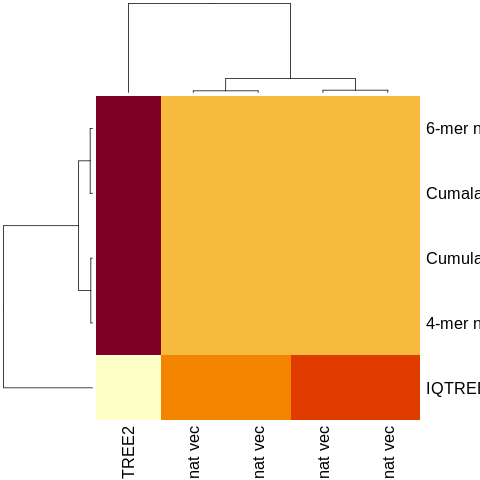

In [24]:
%%R
aa = phyloTop(c(as.phylo(trnat4mer)), normalise = F)
bb = phyloTop(c(as.phylo(trcnat4mer)), normalise = F)
cc = phyloTop(c(as.phylo(trnat6mer)), normalise = F)
dd = phyloTop(c(as.phylo(trcnat6mer)), normalise = F)
tt = phyloTop(c(as.phylo(tree)), normalise = F)

hm = rbind(aa, bb, cc, dd, tt)
row.names(hm) = c("4-mer nat vec",  "Cumalat. 4-mer nat vec", "6-mer nat vec","Cumulat 6-mer nat vec", "IQTREE2")
print(hm)

#pdf("phylotop_dist_based_BRAZIL.pdf", paper = "a4r")
heatmap(as.matrix(dist.cosine(as.matrix(hm))))
#dev.off()


### Cophenetic correlations and RF distance

In [25]:
%%R
print(cor_cophenetic(as.phylo(trnat4mer),dist_nat4mer, method_coef = "spearman"))
print(cor_cophenetic(as.phylo(trcnat4mer),dist_cnat4mer, method_coef = "spearman"))
print(cor_cophenetic(as.phylo(trnat6mer),dist_nat6mer, method_coef = "spearman"))
print(cor_cophenetic(as.phylo(trcnat6mer),dist_cnat6mer, method_coef = "spearman"))
print("#############")
print(cor_cophenetic(as.phylo(trnat4mer),as.phylo(tree), method_coef = "spearman"))
print(cor_cophenetic(as.phylo(trcnat4mer),as.phylo(tree), method_coef = "spearman"))
print(cor_cophenetic(as.phylo(trnat6mer),as.phylo(tree), method_coef = "spearman"))
print(cor_cophenetic(as.phylo(trcnat6mer),as.phylo(tree), method_coef = "spearman"))
print("#############")
print(RF.dist(as.phylo(trnat4mer),as.phylo(tree), normalize = T))
print(RF.dist(as.phylo(trcnat4mer),as.phylo(tree), normalize = T))
print(RF.dist(as.phylo(trnat6mer),as.phylo(tree), normalize = T))
print(RF.dist(as.phylo(trcnat6mer),as.phylo(tree), normalize = T))

[1] 0.9559421
[1] 0.9513473
[1] 0.978355
[1] 0.9783453
[1] "#############"
[1] 0.7607726
[1] 0.7280986
[1] 0.8833394
[1] 0.8645622
[1] "#############"


R[write to console]: Trees are not binary!



[1] 0.9202176


R[write to console]: Trees are not binary!



[1] 0.9245694


R[write to console]: Trees are not binary!



[1] 0.8737987


R[write to console]: Trees are not binary!



[1] 0.8839529


## Bootstraping

In [ ]:
%%R
parNJ <- function(x) nj(parDist(x, method = "euclidean", threads = 4))

bts = boot.phylo(readRDS("trnat4mer.rds"), nat4mer, FUN=parNJ, B=200, mc.cores = 12)
saveRDS(bts, file = "trnat4mer_bts.rds")
bts = boot.phylo(readRDS("trcnat4mer.rds"), cnat4mer, FUN=parNJ, B=200, mc.cores = 12)
saveRDS(bts, file = "trcnat4mer_bts.rds")
bts = boot.phylo(readRDS("trnat6mer.rds"), nat6mer, FUN=parNJ, B=200, mc.cores = 12)
saveRDS(bts, file = "trnat6mer_bts.rds")
bts = boot.phylo(readRDS("trcnat6mer.rds"), cnat6mer, FUN=parNJ, B=200, mc.cores = 12)
saveRDS(bts, file = "trcnat6mer_bts.rds")

In [51]:
%%R
c(readRDS("trnat4mer_bts.rds")/200*100, "4-mer nat vec")

   [1] NA              "0"             "0"             "0"            
   [5] "0"             "0"             "0"             "0.5"          
   [9] "0"             "0.5"           "0.5"           "0"            
  [13] "4"             "2"             "0.5"           "2"            
  [17] "14"            "2.5"           "13"            "3.5"          
  [21] "7"             "16.5"          "0"             "7.5"          
  [25] "0"             "0"             "0"             "6.5"          
  [29] "4.5"           "0"             "0"             "0"            
  [33] "27.5"          "1"             "8"             "7.5"          
  [37] "0"             "0"             "11.5"          "44"           
  [41] "0"             "0"             "0"             "38.5"         
  [45] "27.5"          "0"             "0"             "15.5"         
  [49] "45"            "27"            "31"            "19"           
  [53] "1"             "45.5"          "1"             "0"            
  [57]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[2825] "85.5"          "4"             "100"           "100"          
[2829] "45.5"          "100"           "100"           "97.5"         
[2833] "57.5"          "91"            "22.5"          "25"           
[2837] "11.5"          "100"           "48.5"          "81"           
[2841] "12.5"          "88"            "70"            "69"           
[2845] "100"           "22"            "98.5"          "99.5"         
[2849] "100"           "80"            "62"            "32.5"         
[2853] "90.5"          "77.5"          "47.5"          "100"          
[2857] "50"            "74"            "65.5"          "60"           
[2861] "93"            "63.5"          "97.5"          "77"           
[2865] "60"            "100"           "100"           "100"          
[2869] "100"           "100"           "64.5"          "96.5"         
[2873] "48"            "100"           "51"            "39.5"         
[2877] "83"            "72"            "85"            "33.5"         
[2881]

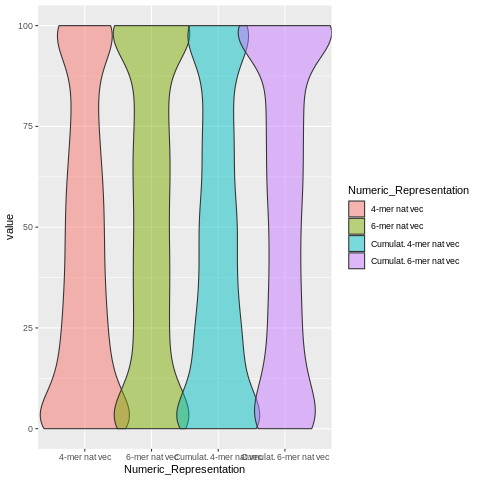

In [52]:
%%R
btsp = as.data.frame(rbind(
  c(readRDS("trnat4mer_bts.rds")/200*100, "4-mer nat vec"),
  c(readRDS("trcnat4mer_bts.rds")/200*100, "Cumulat. 4-mer nat vec"),
  c(readRDS("trnat6mer_bts.rds")/200*100, "6-mer nat vec"),
  c(readRDS("trcnat6mer_bts.rds")/200*100, "Cumulat. 6-mer nat vec")   
))
row.names(btsp) = btsp[,length(btsp[1,])]
btsp = melt(btsp,na.rm = T, id.vars = "V2949")
btsp$value = as.numeric(btsp$value)
names(btsp)[1] = "Numeric_Representation"

supps = btsp %>%
ggplot(aes(x = Numeric_Representation, y = value, fill = Numeric_Representation)) +
  geom_violin(width=1.4, alpha=0.5)

#pdf("FIG_br_Support_dist_based.pdf", paper = "a4r")
plot(supps)
#dev.off()


## Tanglegrams

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
! The tree contained negative edge lengths. If you want to ignore the edges,
you can set `options(ignore.negative.edge=TRUE)`, then re-run ggtree.
Scale for y is a

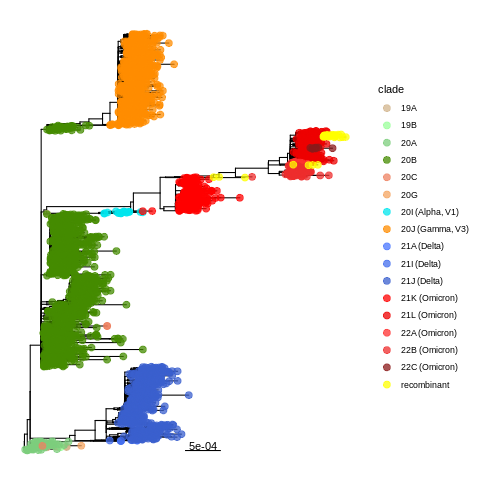

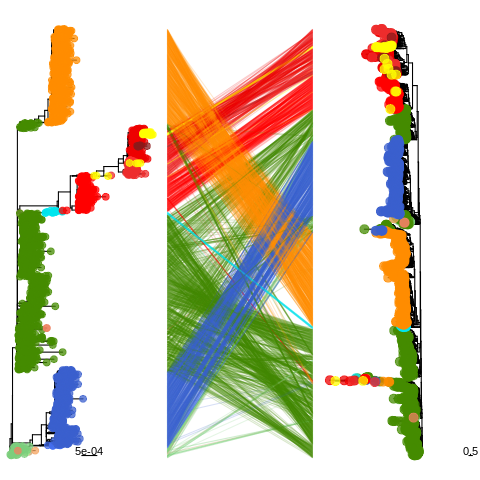

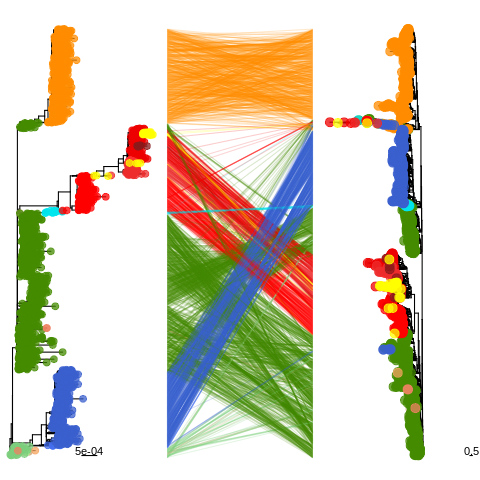

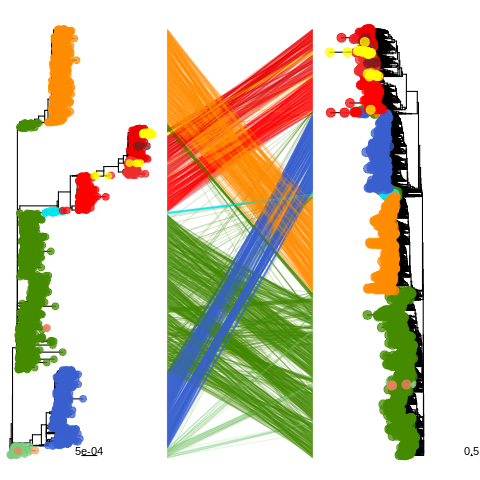

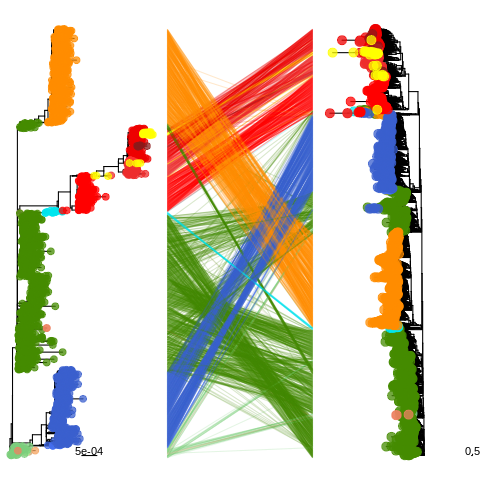

In [26]:
%%R
library(treeio)
library(tidyverse)
library(reshape2)
library(parallelDist)
library(ggtree)
library(ape)
library(phyloTop)
library(stylo)
library(dendextend)
library(phangorn)

normalize <- function(x, na.rm = TRUE) {
  return((x- min(x)) /(max(x)-min(x)))
}

colors_scale = c(
      '19A' = "tan", '19B' = "palegreen1",
      '20A' = "palegreen3", '20B' = "chartreuse4", '20C' = "salmon2", '20G' = "sandybrown",
      '20I (Alpha, V1)' = "turquoise2", '20J (Gamma, V3)' = "darkorange",
      '21A (Delta)' = "royalblue1", '21I (Delta)' = "royalblue2", '21J (Delta)' = "royalblue3",    
      '21K (Omicron)' = "red1", '21L (Omicron)' = "red2",
      '22A (Omicron)' = "firebrick1", '22B (Omicron)' = "firebrick2", '22C (Omicron)' = "firebrick4",
      'recombinant' = "yellow"
)

meta = read.csv("Brazil.sub.3k.nextclade.tsv", sep="\t", stringsAsFactors = F)
names(meta)[1] = "label"

tree = read.iqtree("Brazil.sub.3k.aligned.fasta.contree") 

p = ggtree(tree, ladderize = T)
p$data = left_join(p$data, meta, by="label") 
p1 = p + geom_tippoint(aes(color = clade), alpha = 0.75, size = 3) +
  geom_treescale(width=0.0005, color='black') + 
  theme(legend.position="right") +
  scale_color_manual(values= colors_scale) + 
  ylim(-0.3,3000)

plot(p1)

svg("BR_3k_Clades.svg",width = 20, height = 10)
plot(p1)
dev.off()


ploter = function(treeobj){
	p = ggtree(treeobj, ladderize = T)
	p$data = left_join(p$data, meta, by="label") 
	pt = p + geom_tippoint(aes(color = clade), alpha = 0.75, size = 4) +
  	geom_treescale(width=0.5, color='black') + 
    theme(legend.position="right") +
    scale_color_manual(values = colors_scale) +
    ylim(-0.3,3000)
  	return(pt)
}



T1 <- p1 + theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm"))

T2 <- ploter(as.phylo(readRDS("trnat4mer.rds"))) +  
  scale_x_reverse()+ theme(legend.position="rigth", plot.margin = unit(c(0,0,0,0),"cm")) 

d1 = p$data[T1$data$isTip,]
d1[,5:6] = NULL  
d1$x[] = 1  

d2 = T2$data[T2$data$isTip,1:13]  
d2$x[] = 2  

TTcon <- rbind(d1[,1:13], d2)  

L1 = ggplot(TTcon, aes(x = x, y = y, col = clade, group = label)) +
  geom_line(alpha = 0.2) + theme_void() + 
  theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm")) +
  scale_color_manual(values=colors_scale) + 
  ylim(-0.3,3000)

#svg("tanglegrama_trnat4mer.svg",width = 20, height = 10)
plot(cowplot::plot_grid(T1, L1 ,T2, nrow = 1))
#dev.off()




T2 <- ploter(as.phylo(readRDS("trcnat4mer.rds"))) +  
  scale_x_reverse()+ theme(legend.position="rigth", plot.margin = unit(c(0,0,0,0),"cm")) 

d1 = p$data[T1$data$isTip,]
d1[,5:6] = NULL  
d1$x[] = 1  

d2 = T2$data[T2$data$isTip,1:13]  
d2$x[] = 2  

TTcon <- rbind(d1[,1:13], d2)  

L1 = ggplot(TTcon, aes(x = x, y = y, col = clade, group = label)) +
  geom_line(alpha = 0.2) + theme_void() + 
  theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm")) +
  scale_color_manual(values=colors_scale) + 
  ylim(-0.3,3000)

#svg("tanglegrama_trcnat4mer.svg",width = 20, height = 10)
plot(cowplot::plot_grid(T1, L1 ,T2, nrow = 1))
#dev.off()


T2 <- ploter(as.phylo(readRDS("trnat6mer.rds"))) +  
   scale_x_reverse()+ theme(legend.position="rigth", plot.margin = unit(c(0,0,0,0),"cm")) 

d1 = p$data[T1$data$isTip,]
d1[,5:6] = NULL  
d1$x[] = 1  

d2 = T2$data[T2$data$isTip,1:13]  
d2$x[] = 2  

TTcon <- rbind(d1[,1:13], d2)  

L1 = ggplot(TTcon, aes(x = x, y = y, col = clade, group = label)) +
  geom_line(alpha = 0.2) + theme_void() + 
  theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm")) +
  scale_color_manual(values=colors_scale) + 
  ylim(-0.3,3000)

#svg("tanglegrama_trnat6mer.svg",width = 20, height = 10)
plot(cowplot::plot_grid(T1, L1 ,T2, nrow = 1))
#dev.off()




T2 <- ploter(as.phylo(readRDS("trcnat6mer.rds"))) +  
   scale_x_reverse()+ theme(legend.position="rigth", plot.margin = unit(c(0,0,0,0),"cm")) 

d1 = p$data[T1$data$isTip,]
d1[,5:6] = NULL  
d1$x[] = 1  

d2 = T2$data[T2$data$isTip,1:13]  
d2$x[] = 2  

TTcon <- rbind(d1[,1:13], d2)  

L1 = ggplot(TTcon, aes(x = x, y = y, col = clade, group = label)) +
  geom_line(alpha = 0.2) + theme_void() + 
  theme(legend.position="none", plot.margin = unit(c(0,0,0,0),"cm")) +
  scale_color_manual(values=colors_scale) + 
  ylim(-0.3,3000)
#svg("tanglegrama_trcnat6mer.svg",width = 20, height = 10)
plot(cowplot::plot_grid(T1, L1 ,T2, nrow = 1))
#dev.off()